# Домашнее задание 2. Классификация, детекция.

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.

__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.

Good luck & have fun! :)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/Colab\ Notebooks/DL_sokolov/dataset.zip -d /content/

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
# from skimage import io
from torchvision import transforms
from torchvision.transforms import Resize, Normalize, ToTensor, Compose
import PIL
import cv2
import random

%matplotlib inline
# You may add any imports you need

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform
        f_lst = []
        for root, dirs, files in os.walk(self.data_dir):
          if root == self.data_dir:
            continue
          else:
            f_lst += list(map(lambda x: os.path.join(root, x), files))
        self.files_lst = f_lst

    def __len__(self):
        return len(self.files_lst)
        # return sum([len(os.listdir(self.data_dir + sub)) for sub in os.listdir(self.data_dir)])

    def __getitem__(self, idx):
        img_path = self.files_lst[idx]
        label = int(img_path.split('/')[-2][-3:])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return (img, label)

In [ ]:
def seed_everything(seed):
    # Зафиксировать seed.
    # Это понадобится, чтобы убедиться
    # в правильности работы нашего Optimizer
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(777)

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224,224)),
  transforms.ColorJitter(hue=.05, saturation=.05),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
])

train_transform = transform # transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
# YOU CAN DEFINE AUGMENTATIONS HERE

train_dataset = MyDataset("/content/dataset/dataset/train", transform=train_transform)
val_dataset = MyDataset("/content/dataset/dataset/val", transform=val_transform)

# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET
# OR USE torchvision.datasets.ImageFolder INSTEAD OF MyDataset
# train_dataset = torchvision.datasets.ImageFolder("./dataset/dataset/train", transform=train_transform)
# val_dataset = torchvision.datasets.ImageFolder("./dataset/dataset/val", transform=val_transform)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1298: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. "


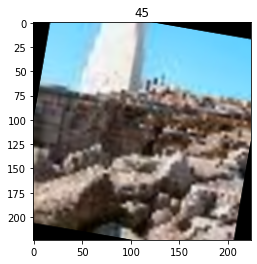

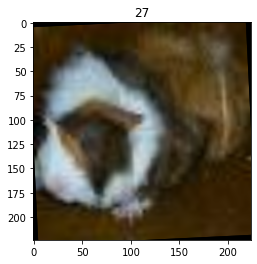

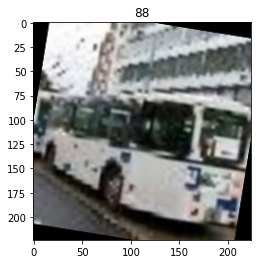

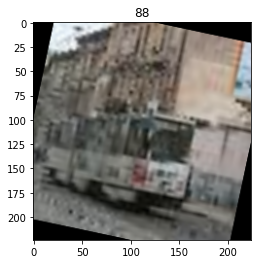

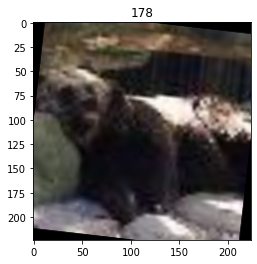

In [ ]:
import time
for _ in range(5):
  img, lab = train_dataset[np.random.randint(0, 10000)]
  to_PIL = transforms.ToPILImage()
  plt.figure()
  plt.imshow(to_PIL(img))
  plt.title(lab)
  # plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.show()

In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=8,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=8,
                                        shuffle=False, num_workers=2)

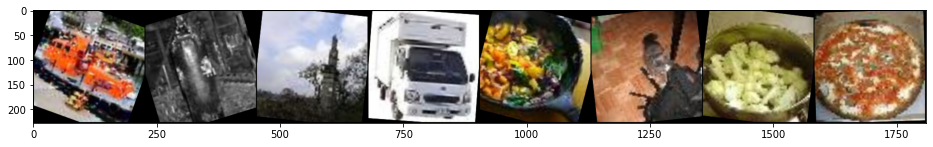

In [ ]:
def imshow(img):
    # img = img / 2 + 0.5  # Убираем нормализацию
    npimg = img.numpy()
    plt.figure(figsize=(16, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Получаем изображения и их метки классов
dataiter = iter(trainloader)
images, labels =  next(dataiter) # dataiter.next()

imshow(torchvision.utils.make_grid(images))

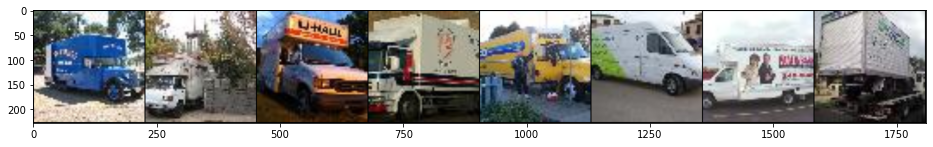

In [ ]:
dataiter = iter(valloader)
images, labels =  next(dataiter) # dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


Необходимо написать функцию predict по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import sys

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(train_dataloader)) as prbar:
      for imgs, labels in train_dataloader:
          imgs, labels = imgs.to(device), labels.to(device)  # Move Batch to GPU
          predicts = model(imgs) # Получаем предсказание модели
          loss = criterion(predicts, labels) # Считаем loss
          # Update weights
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          accuracy = (predicts.argmax(1) == labels).float().mean()

          prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item(), 4)}"
          )
          prbar.update(1)

          total_loss += loss.item()
          total_predictions = np.append(total_predictions, predicts.argmax(1).cpu().detach().numpy())
          num_batches += 1
          total_labels = np.append(total_labels, labels.cpu().detach().numpy())
          all_losses.append(loss.detach().item())
    # metrics = {'loss': total_loss / num_batches}
    # metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return all_losses, total_predictions, total_labels


def predict(model, val_dataloder, criterion, device="cuda:0"):
    model.to(device).eval()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(val_dataloder)) as prbar:
      for imgs, labels in val_dataloder:
          imgs, labels = imgs.to(device), labels.to(device)  # Move Batch to GPU
          predicts = model(imgs) # Получаем предсказание модели
          loss = criterion(predicts, labels) # Считаем loss
          accuracy = (predicts.argmax(1) == labels).float().mean()

          prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item(), 4)}"
            )
          prbar.update(1)

          total_loss += loss.item()
          total_predictions = np.append(total_predictions, predicts.argmax(1).cpu().detach().numpy())
          num_batches += 1
          total_labels = np.append(total_labels, labels.cpu().detach().numpy())
          all_losses.append(loss.detach().item())
    # metrics = {'loss': total_loss / num_batches}
    # metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return all_losses, total_predictions, total_labels


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    all_train_losses = []
    train_acc = []
    all_val_losses = []
    val_acc = []
    for epoch in range(n_epochs):
        print(f"Train Epoch: {epoch}")
        all_losses_train, total_predictions, total_labels = train_one_epoch(
            model, train_dataloader, criterion, optimizer, device)
        all_train_losses.extend(all_losses_train)
        train_acc.append((total_predictions == total_labels).mean())
        print(train_acc[-1])

        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            all_losses_val, total_predictions, total_labels = predict(
                model, val_dataloader, criterion, device)
        all_val_losses.extend(all_losses_val)
        val_acc.append((total_predictions == total_labels).mean())
        print(val_acc[-1])

        if scheduler is not None:
            scheduler.step()

In [ ]:
from torchvision.models import resnet18

# Загрузить предобученную сеть -- pretrained=True
model = resnet18(pretrained=True) # THE MODEL THAT YOU CHOOSE

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 200)
optimizer = torch.optim.RMSprop(model.fc.parameters(), lr=1e-5, momentum=0.8) # YOUR OPTIMIZER

train_dataloader = trainloader # TRAIN DATALOADER WHICH YOU CONSTRUCT
val_dataloader = valloader # VAL DATALOADER WHICH YOU CONSTRUCT
# train_dataset1 = torch.utils.data.Subset(train_dataset, np.random.choice(10000, replace=False, size=int(10000 * 0.1)))
# val_dataset1 = torch.utils.data.Subset(val_dataset, np.random.choice(10000, replace=False, size=int(10000 * 0.1)))
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
#                                                shuffle=True, num_workers=2)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
#                                              shuffle=True, num_workers=2)

criterion = nn.CrossEntropyLoss() # LOSS THAT YOU OPTIMIZE (SHOLD BE CROSS ENTROPY OR SMTH ELSE)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
n_epochs = 20 # NUMBER OF EPOCHS
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Простой тест на проверку правильности написанного кода

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Loss: 5.7627 Accuracy: 0.0: 100%|██████████| 313/313 [00:21<00:00, 14.67it/s]

tests passed


Запустить обучение можно в ячейке ниже.

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs)

Train Epoch: 0


Loss: 3.566 Accuracy: 0.375: 100%|██████████| 12500/12500 [19:42<00:00, 10.57it/s]


0.15369
Validation Epoch: 0


Loss: 3.024 Accuracy: 0.5: 100%|██████████| 1250/1250 [00:22<00:00, 56.63it/s]


0.3463
Train Epoch: 1


Loss: 3.0849 Accuracy: 0.5: 100%|██████████| 12500/12500 [19:24<00:00, 10.73it/s]


0.31212
Validation Epoch: 1


Loss: 2.3789 Accuracy: 0.625: 100%|██████████| 1250/1250 [00:21<00:00, 57.24it/s]


0.4355
Train Epoch: 2


Loss: 3.8638 Accuracy: 0.25: 100%|██████████| 12500/12500 [19:19<00:00, 10.78it/s]


0.35715
Validation Epoch: 2


Loss: 1.697 Accuracy: 0.625: 100%|██████████| 1250/1250 [00:21<00:00, 57.67it/s]


0.4866
Train Epoch: 3


Loss: 2.5896 Accuracy: 0.375: 100%|██████████| 12500/12500 [19:18<00:00, 10.79it/s]


0.37861
Validation Epoch: 3


Loss: 1.7752 Accuracy: 0.5: 100%|██████████| 1250/1250 [00:22<00:00, 56.44it/s]


0.5006
Train Epoch: 4


Loss: 3.4004 Accuracy: 0.125: 100%|██████████| 12500/12500 [19:08<00:00, 10.88it/s]


0.39465
Validation Epoch: 4


Loss: 1.6112 Accuracy: 0.5: 100%|██████████| 1250/1250 [00:23<00:00, 53.57it/s]


0.5158
Train Epoch: 5


Loss: 2.557 Accuracy: 0.375: 100%|██████████| 12500/12500 [19:35<00:00, 10.64it/s]


0.40639
Validation Epoch: 5


Loss: 1.4328 Accuracy: 0.625: 100%|██████████| 1250/1250 [00:21<00:00, 56.95it/s]


0.525
Train Epoch: 6


Loss: 2.4739 Accuracy: 0.375:   4%|▍         | 491/12500 [00:45<18:21, 10.90it/s]


KeyboardInterrupt: ignored

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print()
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))

Loss: 1.2729 Accuracy: 0.625: 100%|██████████| 1250/1250 [00:22<00:00, 55.55it/s]


Оценка за это задание составит 5 баллов


__Ваш отчёт о проделанных экспериментах__: текст писать тут

## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [ ]:
# we will need this library to process the labeling
!pip install xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xmltodict, json

In [ ]:
!unzip -q /content/drive/MyDrive/Colab\ Notebooks/DL_sokolov/archive.zip -d /content/

Датасет мы за вас написали.

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import albumentations as A
from albumentations.pytorch import ToTensorV2
# add any imports you need

class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

In [ ]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.ColorJitter(hue=.05, saturation=.05),
    A.HorizontalFlip(),
    A.Rotate(20)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_transform = A.Compose([A.Resize(224, 224)],
                          bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# transform = transforms.Compose([
#   transforms.ToTensor(),
#   transforms.Resize((224,224)),
#   transforms.ColorJitter(hue=.05, saturation=.05),
#   transforms.RandomHorizontalFlip(),
#   transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
# ])

In [ ]:
train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./train_zip/test", transform=val_transform)

In [ ]:
len(train_dataset)

240

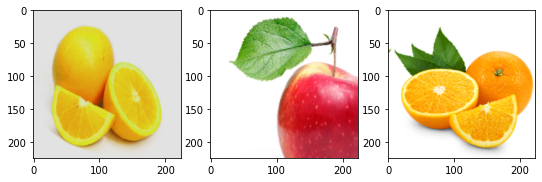

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].imshow(train_dataset[1][0])
ax[1].imshow(train_dataset[2][0])
ax[2].imshow(train_dataset[5][0])
plt.show()

In [ ]:
# from PIL import ImageDraw

# img = train_dataset[35]

# image = torchvision.transforms.ToPILImage()(img[0])
# draw = ImageDraw.Draw(image)
# for box in img[1]['boxes']:
#     draw.rectangle([(box[0], box[1]), (box[2], box[3])])
# image

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации

Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm

In [ ]:
def get_detection_model(num_classes=4):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
import time

In [ ]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in train_dataloader:
          images = list(image.to(device).float() for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

          dict_loss = model(images, targets)
          losses = sum(loss for loss in dict_loss.values())

          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

          n += 1
          global_loss += float(losses.cpu().detach().numpy())

          # prbar.set_description(
          #       f"Batch: {n} "
          #       f"Loss: {round(global_loss / n, 2)} "
          #   )
          # prbar.update(1)
          if n % 10 == 0:
              #
              print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))
              # print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10, scheduler=None):
    for epoch in range(n_epochs):
        print(f"Train Epoch: {epoch}")
        train_one_epoch(model, train_dataloader, optimizer, device)
        print(f"Val Epoch: {epoch}")
        a = evaluate(model, val_dataloader, device)
        print("AUC ON TEST: {:.4f}".format(a))
        if scheduler is not None:
            scheduler.step()

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_transform = train_transform = A.Compose([
    A.Resize(224, 224),
    A.ColorJitter(hue=.05, saturation=.05),
    A.HorizontalFlip(),
    A.Rotate(20),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
val_transform = A.Compose([A.Resize(224, 224), ToTensorV2()],
                          bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 4

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)


data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [ ]:
num_epochs = 5

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=3e-5, momentum=0.9, weight_decay=0.0005)

train(model, num_epochs, data_loader, data_loader_test, optimizer, device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

TypeError: ignored

In [ ]:
train_transform = train_transform = A.Compose([
    A.Resize(224, 224),
    A.ColorJitter(hue=.05, saturation=.05),
    A.HorizontalFlip(),
    A.Rotate(20),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
val_transform = A.Compose([A.Resize(224, 224), ToTensorV2()],
                          bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# HINT: TRAIN TRANSFORM OBVIOUSLY SHOULD BE HARDER THAN THOSE FOR VALIDATION

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)

num_classes = 4
model = get_detection_model(num_classes)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.RMSprop(params, lr=6e-6, momentum=0.9)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=3,
                                               shuffle=True, num_workers=2,
                                               collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=3,
                                             shuffle=False, num_workers=2,
                                             collate_fn=collate_fn)
n_epochs = 40

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs, scheduler)

Train Epoch: 0
Loss value after 10 batches is 15.49
Loss value after 20 batches is 9.05
Loss value after 30 batches is 6.64
Loss value after 40 batches is 5.17
Loss value after 50 batches is 4.26
Loss value after 60 batches is 3.7
Loss value after 70 batches is 3.27
Loss value after 80 batches is 2.93
Loss value after 90 batches is 2.65
Loss value after 100 batches is 2.43
Loss value after 110 batches is 2.27
Loss value after 120 batches is 2.13
Val Epoch: 0
AUC ON TEST: 0.0184
Train Epoch: 1
Loss value after 10 batches is 0.49
Loss value after 20 batches is 0.4
Loss value after 30 batches is 0.43
Loss value after 40 batches is 0.44
Loss value after 50 batches is 0.43
Loss value after 60 batches is 0.43
Loss value after 70 batches is 0.41
Loss value after 80 batches is 0.4
Loss value after 90 batches is 0.41
Loss value after 100 batches is 0.42
Loss value after 110 batches is 0.42
Loss value after 120 batches is 0.42
Val Epoch: 1
AUC ON TEST: 0.0312
Train Epoch: 2
Loss value after 10 b

KeyboardInterrupt: ignored

In [ ]:
train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs, scheduler)

Train Epoch: 0
Loss value after 10 batches is 0.3
Loss value after 20 batches is 0.31
Loss value after 30 batches is 0.32
Loss value after 40 batches is 0.34
Loss value after 50 batches is 0.34
Loss value after 60 batches is 0.34
Loss value after 70 batches is 0.32
Loss value after 80 batches is 0.31
Val Epoch: 0
AUC ON TEST: 0.5229
Train Epoch: 1
Loss value after 10 batches is 0.3
Loss value after 20 batches is 0.32
Loss value after 30 batches is 0.33
Loss value after 40 batches is 0.32
Loss value after 50 batches is 0.32
Loss value after 60 batches is 0.32
Loss value after 70 batches is 0.32
Loss value after 80 batches is 0.31
Val Epoch: 1
AUC ON TEST: 0.5563
Train Epoch: 2
Loss value after 10 batches is 0.2
Loss value after 20 batches is 0.29
Loss value after 30 batches is 0.29
Loss value after 40 batches is 0.31
Loss value after 50 batches is 0.3
Loss value after 60 batches is 0.31
Loss value after 70 batches is 0.3
Loss value after 80 batches is 0.3
Val Epoch: 2
AUC ON TEST: 0.596

__Выведите итоговое качество модели__.

In [ ]:
auc_fin = evaluate(model, val_dataloader, device)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc_fin / 0.91)))

Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [ ]:
image, labels = next(iter(train_dataset))
pred = model(image.unsqueeze(0).to(device))[0]

In [ ]:
from PIL import ImageDraw

image = torchvision.transform.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])

for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь выполнения хотя бы одного из перечисленных критериев:
 - Достичь accuracy не менее 0.56, **не используя resize картинок**, а также **не используя предобученные сети**;
 - Достичь accuracy не менее 0.86, но использовать resize и предобученные из torchvision сети разрешается.

Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы выполнили хоть один из вышеперечисленных критериев и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

In [ ]:
# YOUR CODE

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.